## Assignment: Homework 5
## Name: Kiran Venkata Palla
## Net Id: kvp246

# Assignment 1 => Data cleaning and merging, linear regression (1st and 2nd degree polynomial), log-scales, likelihood tests

In [82]:
# Loading the required libraries
%pylab inline
import geopandas as gp
import pandas as pd
import os
import json
import pylab as pl
import urllib2
import numpy as np
import scipy as sp
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Using the matplotlib customizing file
jsonFile = urllib2.urlopen('https://raw.githubusercontent.com/fedhere/PUI2015_fbianco/master/fbb_matplotlibrc.json')
s = json.load(jsonFile)
plt.rcParams.update(s)

Populating the interactive namespace from numpy and matplotlib


I am using geopanda. that is **not required** for this particular exercise, but geopand works with geospacial data: the shape files that we get from pluto for example.

PLEASE REMEMBER: seed your random functions if you need to use any, label your axes clearly, comment your code, use PEP8!


##We will use 2 different datasets.
##an interesting urban question is "can we measure and predict energy use based on observables that are easier to be acquired". for example the urban observatory at CUSP can monitor lights: they are a realtively easy observable. All you need is a camera, and a pipeline to process your data. But how does the light coming from a window relate to the total energy consumption? We generally postulate that light is a proxy for occupancy, and that occupancy is a good predictor of energy consumption.
##so let's test if the last link holds. If we have data on the energy consumed by a __building__ how well does that relate to the number of units in the building?

## data on energy consumption can be found here for the city of NY https://data.cityofnewyork.us/Environment/Energy-and-Water-Data-Disclosure-for-Local-Law-84-/rgfe-8y2z  

In [28]:
# Using NYC energy consumption data
nrg = gp.GeoDataFrame.from_csv("Energy_and_Water_Data_Disclosure_for_Local_Law_84__2013_.csv")
print nrg.columns

Index([u'NYC Borough, Block, and Lot (BBL)', u'Co-reported BBL Status',
       u'BBLs Co-reported',
       u'Reported NYC Building Identificaiton Numbers (BINs)',
       u'Street Number', u'Street Name', u'Borough', u'Zip Code',
       u'DOF Benchmarking Submission Status', u'Site EUI(kBtu/ft2)',
       u'Weather Normalized Site EUI(kBtu/ft2)', u'Source EUI(kBtu/ft2)',
       u'Weather Normalized Source EUI(kBtu/ft2)',
       u'Municipally Supplied Potable Water - Indoor Intensity (gal/ft²)',
       u'Automatic Water Benchmarking Eligible', u'Reported Water Method',
       u'ENERGY STAR Score', u'Total GHG Emissions(MtCO2e)',
       u'Direct GHG Emissions(MtCO2e)', u'Indirect GHG Emissions(MtCO2e)',
       u'Reported Property Floor Area (Building(s)) (ft²)',
       u'DOF Property Floor Area (Buildngs and Parking)(ft2)',
       u'Primary Property Type - Self Selected', u'DOF Number of Buildings'],
      dtype='object')


#however this datasets does not have the number of units. We can find that in the Pluto dataset.
reading in the Pluto data for manhattan, which will give me the number of units per building   Manhattan/MNMapPLUTO.shp

In [29]:
# Using PLUTO data shape file for Manhattan borough
bsize = gp.GeoDataFrame.from_file("Manhattan/MNMapPLUTO.shp")
print bsize.columns

Index([    u'APPBBL',    u'APPDate',    u'Address', u'AllZoning1',
       u'AllZoning2', u'AreaSource', u'AssessLand',  u'AssessTot',
              u'BBL',   u'BldgArea',  u'BldgClass',  u'BldgDepth',
        u'BldgFront',      u'Block',   u'BoroCode',    u'Borough',
         u'BsmtCode',  u'BuiltCode',   u'BuiltFAR',     u'CB2010',
               u'CD',     u'CT2010',    u'ComArea',    u'CommFAR',
          u'CondoNo',    u'Council',  u'EDesigNum',  u'Easements',
       u'ExemptLand',  u'ExemptTot',        u'Ext',   u'FacilFAR',
       u'FactryArea',   u'FireComp', u'GarageArea', u'HealthArea',
         u'HistDist', u'IrrLotCode',    u'LandUse',   u'Landmark',
              u'Lot',    u'LotArea',   u'LotDepth',   u'LotFront',
          u'LotType',  u'LtdHeight', u'MAPPLUTO_F',   u'NumBldgs',
        u'NumFloors', u'OfficeArea',  u'OtherArea',   u'Overlay1',
         u'Overlay2',  u'OwnerName',  u'OwnerType', u'PLUTOMapID',
       u'PolicePrct',   u'ProxCode',    u'ResArea',   u'ResidF

in pandas scatter_matrix will plot each column agains each other. that is a great way to begin inspecting your data (though be careful cause it is computationally comsuming for large datasets) 



array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000000168FE908>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x000000003C987B38>]], dtype=object)

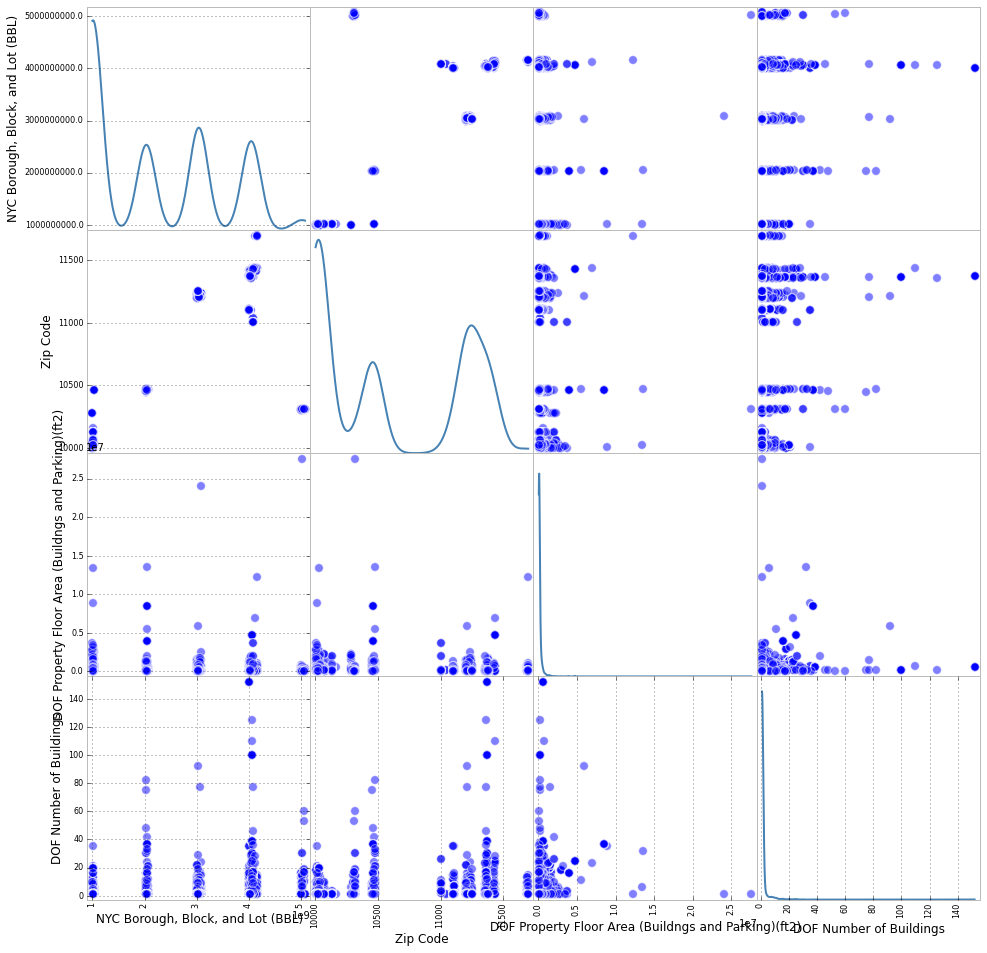

In [30]:
# Checking for discrepancies within columns based on scatter matrix output
from pandas.tools.plotting import scatter_matrix
scatter_matrix (nrg, s=300, figsize=(16, 16), diagonal='kde')

it will show me correlations between variables, but it will also show me what can and 
cannot be plotted trivially in my dataset! here only a few columns can be plotted: 
those that contain only numbers (and possibly NaN's), but most columns contain rows that cannot be converted to float (e.g. entries like 'See Primary BBL' in several rows for the energy dataframe 'Site EUI(kBtu/ft2) ' column) , so Pandas refuses to plot them, cause it does not know what to do with those entries. 
The columns I am interested in are in fact u'Site EUI(kBtu/ft2)' which is a measure of the energy consumed PER SQ FOOT by a building, and then the building area: for eg.       u'Reported Property Floor Area (Building(s)) (ft²)'. Neither gets plotted: i need to remove all values that cannot conver to float in order to use the columns and convert them to float arrays and do math with them. 

Below I created a function that returns True if what is passed as argument can be converted to a float, and False otherwise. I do it with the Try/Except structure. it is a very useful python functionality that you should look into.  
this has to be done entry by entry: if you gve t a series you get error "cannot convert the series to <type 'float'>"

However you can pass it a whole array by using it in conjunction with
np.vectorize (look up the syntax!) which will implement a for loop for you under the hood to pass the series entry by entry to your function.


_**From the energy consumption data, columns of interest for this problem would be Site EUI(kBtu/ft2) and Reported Property Floor Area (Building(s)) (ft²) respectively which will help in computing total energy consumed by a building. In the above scatter plot, we can see that both of these variables are not present which confirms the presence of discrepant values within these columns. Before going ahead with further analysis, these discrepant values within these columns needs to be treated first.**_

In [31]:
# Checking for data types of the columns
print dtype(nrg['Site EUI(kBtu/ft2)'])
print dtype(nrg['Reported Property Floor Area (Building(s)) (ft²)'])

object
object


_**Ideally we should be seeing the data types of required columns as float instead object output is being seen. This is being casued due to the presence of some string values within these columns that needs to be addressed.**_

In [32]:
# Using convert_objects function on the columns to convert string values into NaNs
nrg['Site EUI(kBtu/ft2)'] = nrg['Site EUI(kBtu/ft2)'].convert_objects(convert_numeric=True)
nrg['Reported Property Floor Area (Building(s)) (ft²)'] = nrg['Reported Property Floor Area (Building(s)) (ft²)'].convert_objects(convert_numeric=True)

print dtype(nrg['Site EUI(kBtu/ft2)'])
print dtype(nrg['Reported Property Floor Area (Building(s)) (ft²)'])

float64
float64


_**Now we see that the data types of required columns are converted to float.**_

In [34]:
# Checking whether the conversion worked on 'Site EUI(kBtu/ft2)' column in nrg data
# Checking for discrepancies if any for BBL column in PLUTO data 
print nrg['Site EUI(kBtu/ft2)'].astype(float)
print bsize.BBL.astype(float)

Record Number
16099      180.5
500         82.1
5017       137.7
5116       103.2
363         74.0
6876        36.4
10714      114.8
1214       130.0
1544       138.3
1905     56909.0
2301        88.2
15059       15.7
674          NaN
2537        85.7
2841       195.7
2945        79.1
15120      144.1
3053       200.9
4233       104.6
4777        86.7
4912       102.1
5210        21.2
5295        78.3
1575         NaN
15025       55.2
4208        83.2
4799       145.1
1568        59.4
5427        88.7
5476       100.8
          ...   
14559        NaN
14560        NaN
14748        NaN
14753        NaN
13582        NaN
13947        NaN
14777        NaN
14779        NaN
14409        NaN
13262        NaN
13261        NaN
12523        NaN
12529        NaN
12536        NaN
13929        NaN
13944        NaN
13945        NaN
13821        NaN
13829        NaN
13837        NaN
13838        NaN
13847        NaN
14352        NaN
12976        NaN
12978        NaN
12984        NaN
12987        NaN


_**As no errors were reported, we can safely conclude that all the discrepant string values in the required columns are converted to NaNs.**_

#TO MERGE THE DATASET WE NEED A COMMON COLUMN
here is where you want to merge the datasets. You need a common column: the building id BBL
However the name of this variable (column) in the Energy dataset is     'NYC Borough, Block, and Lot (BBL)'. create a column 'BBL' in the nrg dataset to pass it to the 'on' keyword argument of the merge pandas method: pd.merge(..... on=['BBL']) will use the common column 'BBL' to join the information from the 2 datasets for each BBL value (check out the complete syntax!) 

In [38]:
# Renaming the column name for Building Id
nrg = nrg.rename(columns = {'NYC Borough, Block, and Lot (BBL)':'BBL'})

# Subsetting only the required columns from the nrg data
nrgData = nrg[['BBL', 'Site EUI(kBtu/ft2)', 'Reported Property Floor Area (Building(s)) (ft²)']]

# Subsetting only the required columns from the Manhattan PLUTO data
bsizeData = bsize[['BBL', 'UnitsRes', 'UnitsTotal']]

# Merging the nrg data and PLUTO data on BBL column
energyData = pd.merge(left=nrgData,right=bsizeData, on='BBL')
energyData['totalEnergy'] = energyData['Site EUI(kBtu/ft2)'] * energyData['Reported Property Floor Area (Building(s)) (ft²)']
print energyData.info()
print energyData.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6545 entries, 0 to 6544
Data columns (total 6 columns):
BBL                                                 6545 non-null float64
Site EUI(kBtu/ft2)                                  5097 non-null float64
Reported Property Floor Area (Building(s)) (ft²)    5600 non-null float64
UnitsRes                                            6545 non-null int64
UnitsTotal                                          6545 non-null int64
totalEnergy                                         5089 non-null float64
dtypes: float64(4), int64(2)
memory usage: 357.9 KB
None
          BBL  Site EUI(kBtu/ft2)  \
0  1005050001                82.1   
1  1021420100               137.7   
2  1021750080               103.2   
3  1003360005                74.0   
4  1008070028               130.0   

   Reported Property Floor Area (Building(s)) (ft²)  UnitsRes  UnitsTotal  \
0                                            235370         0          24   
1                   

C:\Users\kiran.pv\AppData\Local\Continuum\Anaconda\lib\site-packages\pandas\core\index.py:1695: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  indexer = self._engine.get_indexer(target.values)


once you have the dataframe with all the info you want, you want to plot 
Energy vs Number of Units in the Building. 
Remember: Energy TOTAL, not per sq ft...
Here you can choose what you think makes more sense for the number of units: all units, residential units...
make a 'natural' scale scatter plot first it will look really bad cause all the datapoints are at very low Unit numbers while the Unit number range actually goes up to 8000.
perhaps zoom into the region where most points are by cutting your x and y axis plotted: e,g, use xlim=(1000,1e10), ylim=(1,1000), where the numbers to be plugged in depend on exactly what you chose to plot

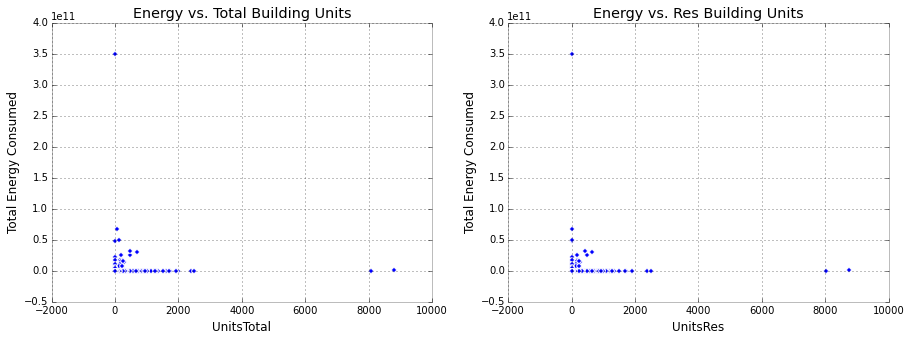

In [41]:
# Using subplots for plotting totalEnergy vs both UnitsTotal and UnitsRes
fig, (ax1, ax2) = pl.subplots(1, 2, figsize=(15, 5))
ax1.scatter(energyData['UnitsTotal'], energyData['totalEnergy'])
ax1.set_xlabel("UnitsTotal")
ax1.set_ylabel("Total Energy Consumed")
ax1.set_title("Energy vs. Total Building Units")

ax2.scatter(energyData['UnitsRes'], energyData['totalEnergy'])
ax2.set_xlabel("UnitsRes")
ax2.set_ylabel("Total Energy Consumed")
ax2.set_title("Energy vs. Res Building Units")

_**From the above plots, we can see that no clear trend is visible due to few extreme values present in the data across both total energy and building unit columns. To deal with this, we need to scale the axes to smaller values where major distribution of data values are present in order to study the trend present, if any.**_

(1000, 10000000000.0)

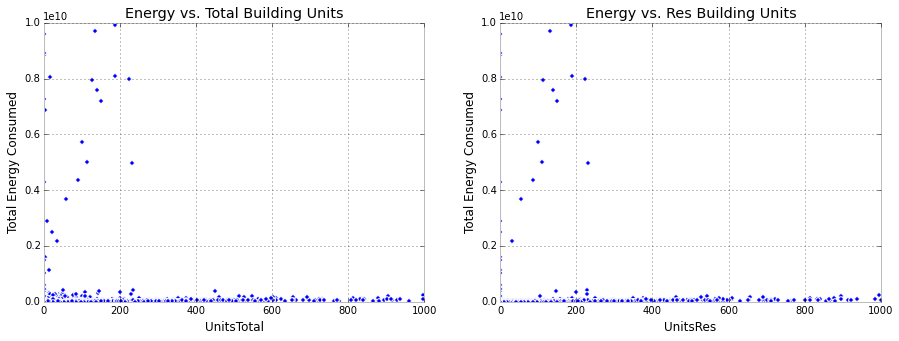

In [44]:
# Using subplots for plotting totalEnergy vs both UnitsTotal and UnitsRes
fig, (ax1, ax2) = pl.subplots(1, 2, figsize=(15, 5))
ax1.scatter(energyData['UnitsTotal'], energyData['totalEnergy'])
ax1.set_xlabel("UnitsTotal")
ax1.set_ylabel("Total Energy Consumed")
ax1.set_title("Energy vs. Total Building Units")
ax1.set_xlim([1,1000])
ax1.set_ylim([1000,1e10])

ax2.scatter(energyData['UnitsRes'], energyData['totalEnergy'])
ax2.set_xlabel("UnitsRes")
ax2.set_ylabel("Total Energy Consumed")
ax2.set_title("Energy vs. Res Building Units")
ax2.set_xlim([1,1000])
ax2.set_ylim([1000,1e10])

_**After adjusting for the x and y axes limit values, we can see better plots but even with these we fail to identify any useful relationships between the energy and building unit columns. Next we will try using the log plots rather than the original values.**_

when the points in a plot all look scrunched against the axis try a log plot! in pandas you enable that with the keyword 'loglog' :
bblnrgdata.plot(..... loglog=True)

NOTICE THAT YOU WILL STILL HAVE TO CUT YOUR DATASET! in my data i had a lot of energy datapoints that were exactly 0. I removed these "outliers" which I think are truly outliers in the sense that they are misreported numbers. you can remove the data that have nrg==0 (or nrg < some sensible threshold choice) by indexing your array:
something like bblnrgdata_cut = bblnrgdata[bblnrgdata.nrg>1000]

also i removed the buildings with several thousand units. points like that at the edge of my range would have a lot of "LEVERAGE", however  they are not suprious entries like the 0, which i believe are missing values, or perhaps abandoned lots. these are good datapoint that i need to throw away functionally for my analysis to work, but that should be stated clearly.


(1000, 10000000000.0)

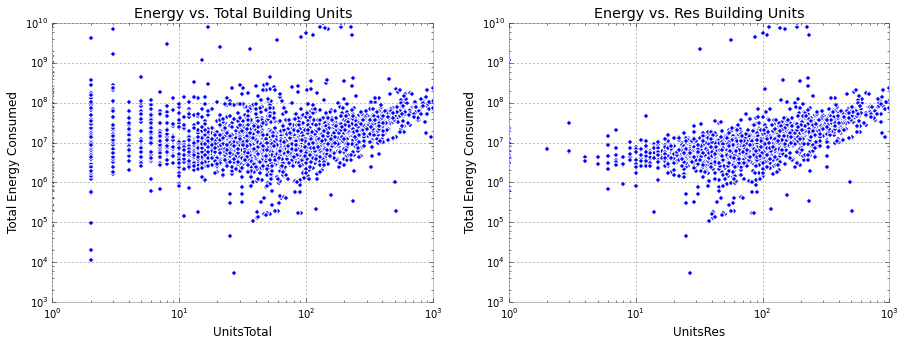

In [45]:
# Using subplots for plotting totalEnergy vs both UnitsTotal and UnitsRes
fig, (ax1, ax2) = pl.subplots(1, 2, figsize=(15, 5))
ax1.scatter(energyData['UnitsTotal'], energyData['totalEnergy'])
ax1.set_xlabel("UnitsTotal")
ax1.set_ylabel("Total Energy Consumed")
ax1.set_title("Energy vs. Total Building Units")
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlim([1,1000])
ax1.set_ylim([1000,1e10])

ax2.scatter(energyData['UnitsRes'], energyData['totalEnergy'])
ax2.set_xlabel("UnitsRes")
ax2.set_ylabel("Total Energy Consumed")
ax2.set_title("Energy vs. Res Building Units")
ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.set_xlim([1,1000])
ax2.set_ylim([1000,1e10])

_**Loglog plots of energy vs building unit columns shows some linear trend between them compared to the earlier plots. Next we try to build a linear regression model trying to estimate the relationship between energy consumed and building size.**_

In [53]:
# Checking for any NaN values in UnitsTotal and UnitsRes columns
print energyData['UnitsTotal'].describe()
print energyData['UnitsRes'].describe()

# Computing pearson correlation coefficient between the two columns
sp.stats.pearsonr(energyData['UnitsTotal'],energyData['UnitsRes'])

count    6545.000000
mean      108.214515
std       251.438409
min         0.000000
25%        16.000000
50%        57.000000
75%       115.000000
max      8800.000000
Name: UnitsTotal, dtype: float64
count    6545.000000
mean       96.519939
std       247.866435
min         0.000000
25%         0.000000
50%        48.000000
75%       106.000000
max      8756.000000
Name: UnitsRes, dtype: float64


(0.97922229333698396, 0.0)

_**We have two building unit columns namely: UnitsTotal and UnitsRes. Based on correlation value of 0.97, we can safely conclude that there is a high correlation between the two columns and for linear regression model, we can use only UnitsTotal and similar estimation results would hold true for UnitsRes column as well.**_

Now fit a line through the data. you can use whatever you want to do it: 
statsmodels, scipy, any other package, or write your own minimization of the residuals
## BUT REMEMBER: we see hints of a lienar relation in log space! so we want to fit a line to the log of our variables, not the variables themselves:

if you used statsmodels it would look something like this:

In [149]:
# Subsetting for extreme values in both totalEnergy and UnitsTotal columns
finalData = energyData[(energyData['UnitsTotal']>0) & (energyData['UnitsTotal']<1000) & (energyData['totalEnergy']>0) & (energyData['totalEnergy']<1e10)]
print finalData.info()

print finalData['totalEnergy'].describe()
print finalData['UnitsTotal'].describe()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4956 entries, 0 to 5796
Data columns (total 6 columns):
BBL                                                 4956 non-null float64
Site EUI(kBtu/ft2)                                  4956 non-null float64
Reported Property Floor Area (Building(s)) (ft²)    4956 non-null float64
UnitsRes                                            4956 non-null int64
UnitsTotal                                          4956 non-null int64
totalEnergy                                         4956 non-null float64
dtypes: float64(4), int64(2)
memory usage: 271.0 KB
None
count    4.956000e+03
mean     4.803405e+07
std      4.524389e+08
min      5.344000e+03
25%      5.849962e+06
50%      9.202275e+06
75%      1.826103e+07
max      9.926784e+09
Name: totalEnergy, dtype: float64
count    4956.000000
mean      100.375504
std       123.636226
min         1.000000
25%        26.000000
50%        63.000000
75%       121.000000
max       997.000000
Name: UnitsTotal, d

In [66]:
# Fitting linear regression model on original columns
model = smf.ols(formula = 'totalEnergy ~ UnitsTotal', data = finalData).fit()
print model.summary()

                            OLS Regression Results                            
Dep. Variable:            totalEnergy   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.6722
Date:                Sun, 18 Oct 2015   Prob (F-statistic):              0.412
Time:                        19:19:05   Log-Likelihood:            -1.0581e+05
No. Observations:                4956   AIC:                         2.116e+05
Df Residuals:                    4954   BIC:                         2.116e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept   4.376e+07   8.28e+06      5.285      0.0

_**From the above linear regression model output, we can see that R-squared value is 0 which signifies that there is no relationship between the original values of the columns. Next we will try to look at log values of the columns.**_

In [150]:
# Computing log versions of the columns
finalData.loc[:,('logEnergy')] = np.log10(finalData['totalEnergy'])
finalData.loc[:,('logUnits')] = np.log10(finalData['UnitsTotal'])
finalData.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4956 entries, 0 to 5796
Data columns (total 8 columns):
BBL                                                 4956 non-null float64
Site EUI(kBtu/ft2)                                  4956 non-null float64
Reported Property Floor Area (Building(s)) (ft²)    4956 non-null float64
UnitsRes                                            4956 non-null int64
UnitsTotal                                          4956 non-null int64
totalEnergy                                         4956 non-null float64
logEnergy                                           4956 non-null float64
logUnits                                            4956 non-null float64
dtypes: float64(6), int64(2)
memory usage: 348.5 KB


remember to choose wisely which is your DEPENDENT and which is your INDEPENDENT variable. 
both for what you want to do logically (what changes as a functino of what) but also based on which  variable has a 'sensible' distribution that allows you to fit a function to it: 
    you need your independent variable to span a large range, and to be spread somewhat evenly in the range, 
    rather than just clustered in a spot
    


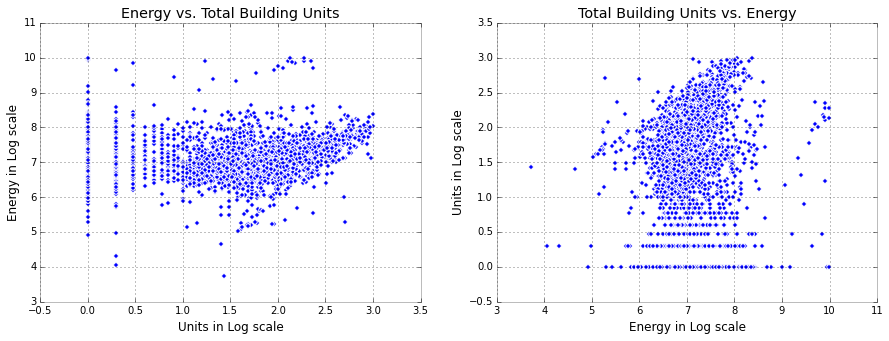

In [80]:
# Using subplots for plotting log scales of totalEnergy vs UnitsTotal and vice versa
fig, (ax1, ax2) = pl.subplots(1, 2, figsize=(15, 5))
ax1.scatter(finalData['logUnits'], finalData['logEnergy'])
ax1.set_xlabel("Units in Log scale")
ax1.set_ylabel("Energy in Log scale")
ax1.set_title("Energy vs. Total Building Units")

ax2.scatter(finalData['logEnergy'], finalData['logUnits'])
ax2.set_xlabel("Energy in Log scale")
ax2.set_ylabel("Units in Log scale")
ax2.set_title("Total Building Units vs. Energy")

_**In this problem, we are trying to estimate relationship between Energy consumed and Building units. Through use of log scale scatter plots, we have kind of identified some linear relation between the two columns. Now for the final model equation , the choice of dependent variable is based on the Y axis of the scatter plot. From the above two plots, left one takes Energy on Y axis and right one takes Units on Y axis. Among these two, we can see that there is some linear trend which is observed with respect to Energy as Units increase on X axis. On the right side plot, we hardly notice any relation existing between the two variables. We can further confirm this by looking the linear regression model outputs.**_

try making a fit for energy vs units AND a fit for units vs energy. 
tell me which is better. 

##look at the fit summary: which is better? could you do a likelihood ratio test here? why or why not??

0.0112407189849
Intercept    6.914340
logUnits     0.074822
dtype: float64
0.0112407189849
Intercept    0.597087
logEnergy    0.150234
dtype: float64


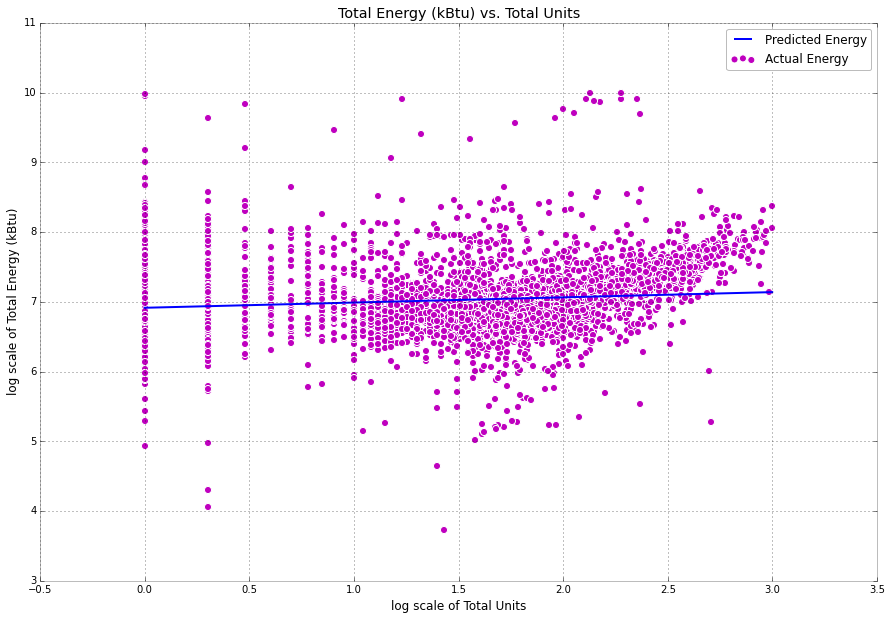

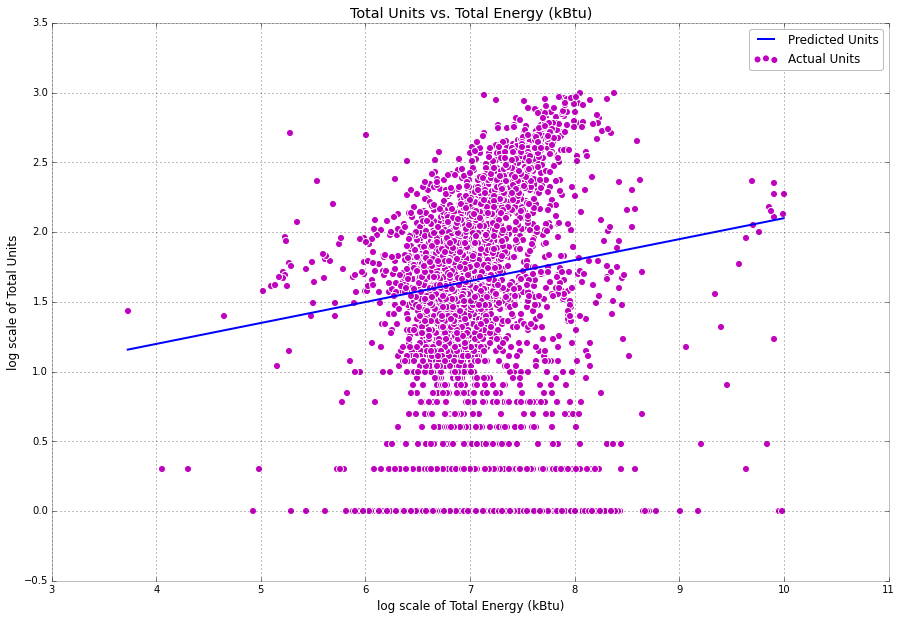

In [183]:
# Fitting linear regression model on log of Energy vs log of Units
model1 = smf.ols(formula = 'logEnergy ~ logUnits', data = finalData).fit()
print model1.rsquared
print model1.params

# Using limit values for linspace function
lower1 = np.min(finalData['logUnits'])
upper1 = np.max(finalData['logUnits'])

# Generating predicted values using the above model1 parameters
x1 = pd.DataFrame({'logUnits': np.linspace(lower1, upper1, 10)})
predicted1 = model1.predict(x1)

# Plotting the actual and predicted values with respect to Units on X axis
pl.figure(figsize=(15,10))
pl.scatter(finalData['logUnits'], finalData['logEnergy'], s = 50, c = 'm', label='Actual Energy')
pl.plot(x1, predicted1, c = 'blue', label='Predicted Energy')
pl.legend(loc='upper right')
pl.xlabel('log scale of Total Units')
pl.ylabel('log scale of Total Energy (kBtu)')
pl.title('Total Energy (kBtu) vs. Total Units')

# Fitting linear regression model on log of Units vs log of Energy
model2 = smf.ols(formula = 'logUnits ~ logEnergy', data = finalData).fit()
print model2.rsquared
print model2.params

# Using limit values for linspace function
lower2 = np.min(finalData['logEnergy'])
upper2 = np.max(finalData['logEnergy'])

# Generating predicted values using the above model2 parameters
x2=pd.DataFrame({'logEnergy': np.linspace(lower2,upper2,10)})
predicted2 = model2.predict(x2)

# Plotting the actual and predicted values with respect to Units on X axis
pl.figure(figsize=(15,10))
pl.scatter(finalData['logEnergy'], finalData['logUnits'], s = 50, c = 'm', label='Actual Units')
pl.plot(x2, predicted2, c = 'blue', label='Predicted Units')
pl.legend(loc='upper right')
pl.xlabel('log scale of Total Energy (kBtu)')
pl.ylabel('log scale of Total Units')
pl.title('Total Units vs. Total Energy (kBtu)')

_**From the above plots, we can see that both the models ended up giving the same R-squared value and also the p-values for X variable is significant. However, major difference lies while looking at the plots. First plot "Energy vs. Units" seems to showing a linear trend in comparison with the other one. So model 1 is better which tries to predict energy as a function of units. Likelihood ratio test is not applicable here as both are trying to test different hypotheses and are not nested models.**_

##now fit a second degree curve to it: a*x^2+b*x+c. 
that is still called a linear fir by the way, the "linear" definition refers to the PARAMETERS being linear, not to the variable!
you can use np.polyfit for example (an example showned in the other assignment notebook), with order 2 instead of 1,

np.polyfit(x, y, 2)

or statmodels.formula.api passing a formula like 

formula = 'y ~ 1 + x + I(x ^ 2.0)'

##look at the fit summary: which is better? could you do a likelihood ratio test here? why or why not??

R-squared value for Energy vs Units model: 0.167309379036
Intercept             7.289940
logUnits             -0.790610
I(logUnits ** 2.0)    0.329858
dtype: float64
R-squared value for Units vs Energy model: 0.0301937592108
Intercept             -7.021171
logEnergy              2.267166
I(logEnergy ** 2.0)   -0.146302
dtype: float64


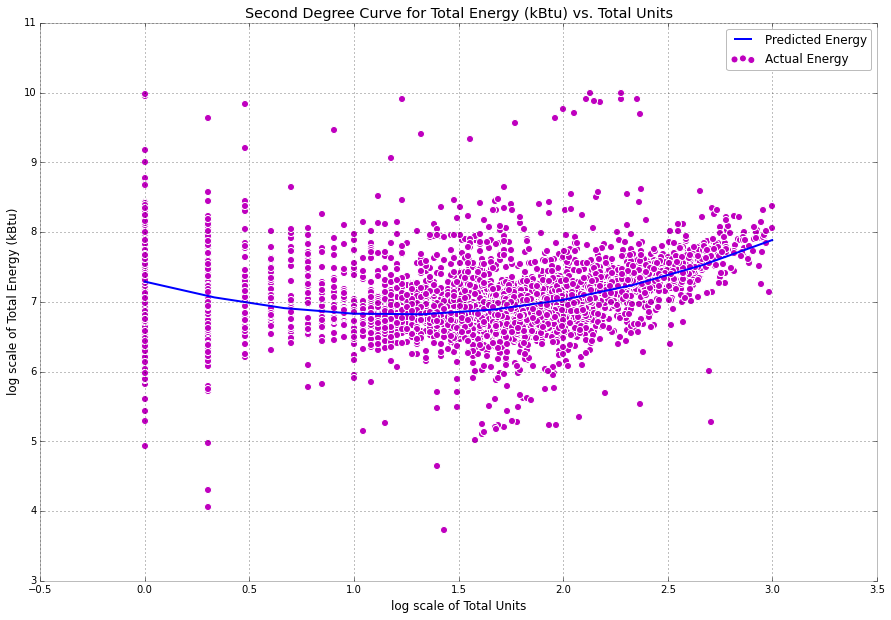

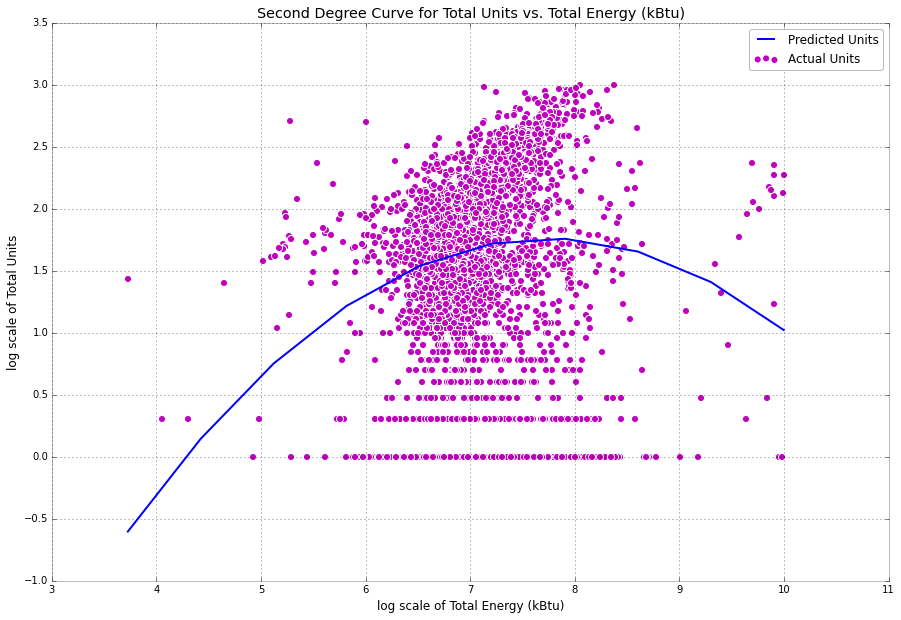

In [186]:
# Fitting a second degree curve linear regression model for Energy vs Units
model1 = smf.ols(formula = 'logEnergy ~ 1 + logUnits + I(logUnits ** 2.0)', data = finalData).fit()
print "R-squared value for Energy vs Units model:", model1.rsquared
print model1.params

# Using limit values for linspace function
lower1 = np.min(finalData['logUnits'])
upper1 = np.max(finalData['logUnits'])

# Generating predicted values using the above model1 parameters
x1 = pd.DataFrame({'logUnits': np.linspace(lower1, upper1, 10)})
predicted1 = model1.predict(x1)

# Plotting the actual and predicted values with respect to Units on X axis
pl.figure(figsize=(15,10))
pl.scatter(finalData['logUnits'], finalData['logEnergy'], s = 50, c = 'm', label='Actual Energy')
pl.plot(x1, predicted1, c = 'blue', label='Predicted Energy')
pl.legend(loc='upper right')
pl.xlabel('log scale of Total Units')
pl.ylabel('log scale of Total Energy (kBtu)')
pl.title('Second Degree Curve for Total Energy (kBtu) vs. Total Units')

# Fitting a second degree curve linear regression model for Units vs Energy
model2 = smf.ols(formula = 'logUnits ~ 1 + logEnergy + I(logEnergy ** 2.0)', data = finalData).fit()
print "R-squared value for Units vs Energy model:", model2.rsquared
print model2.params

# Using limit values for linspace function
lower2 = np.min(finalData['logEnergy'])
upper2 = np.max(finalData['logEnergy'])

# Generating predicted values using the above model2 parameters
x2 = pd.DataFrame({'logEnergy': np.linspace(lower2, upper2, 10)})
predicted2 = model2.predict(x2)

# Plotting the actual and predicted values with respect to Units on X axis
pl.figure(figsize=(15,10))
pl.scatter(finalData['logEnergy'], finalData['logUnits'], s = 50, c = 'm', label='Actual Units')
pl.plot(x2, predicted2, c = 'blue', label='Predicted Units')
pl.legend(loc='upper right')
pl.xlabel('log scale of Total Energy (kBtu)')
pl.ylabel('log scale of Total Units')
pl.title('Second Degree Curve for Total Units vs. Total Energy (kBtu)')

_**Looking at above plots consisting of second degree curves, we can see that both the first model returns a higher R-squared value compared to the second one. This fact is even confirmed by the plot of Energy vs Units, and therefore we can conclude that model 1 i.e. Energy vs Units is a better model. Even in this case, Likelihood ratio (lr) test is not applicable as both are trying to test different hypotheses and are not nested models.**_

_**However, lr test can be performed on say model1 i.e. Energy vs. Units, across both single degree and second degree linear equations. In comparison with second degree equation, we are restricting the presence of second degree term in the single degree linear equation and lr test compares the log likelihoods of the two models and tests whether this difference is statistically significant.**_   

EXTRA CREDIT: 
    
use WLS the weighted sq fit instead of OLS. you need to give weights to your points: 
estimates of the errors. the easiest thing is the sqrt of the datapoint value.
if you want to be more sophisticated you can estimate the variance of your data
near each point and use that 

Lastly: do it by hand and create a function that minimizes the residuals: 
       
the residuals are the sum of the differences between data and model: 
in the case of a line fit model (and you can use your errors if you did the extra credit!)

sum(np.log(bblnrgdatacut.nrg) - np.log(bblnrgdatacut.UnitsTotal)*a+b )^2

where a and b are the parameters returned by the line fitter. 
for each data point you can calculate the model at different values : for example in a range B = np.arange (-100, 100, 1) for the intercept, and A = np.arange(-50.0, 50.0, 0.5) for the slope

write it as a nested for loop (or challenge yourself and vectorize it!) with a loop inside another ranging all poissible combinations of the 2 variables (i use enumerate to get both an index from 0 to the size of my array, which i assign to i (and j) and the value of the array at that index - look up the syntax!):


for i,a in enumerate(A):

    for j,b in enumerate(B):
    
         Lsurface[i][j].....

this gives you a 2D array that represents your likelihood surface! what we do to find a good fit is find the minimum (lowest point) on this surface. 

you can plot a surface (a 2D array) with pl.imshow(Lsurface) as a "heatmap"

but when you do that you will find that the plot is very uninformative. just like you did before with the data, plot the log of it (pl.imshow(np.log(Lsurface))
and see if it helps!
also make sure your x and y axes tick numbers represent the range of values, not the cell index, which is the default for imshow. do that with the keyword extent: 
pl.imshow(Lsurface, .... , extent = [minimum, and max of your y array, minimum, and max of your x array]...) (notice that the numbers are switched! make sure to verify which axis is the slope, which is the intercept)

In [23]:
##create the array
##[...]
##pl.figure(figsize=(10,10))
##pl.title ("log likelihood surface", fontsize = 22)
##pl.imshow(np.log(Lsurface), extent = ..., aspect=...)
##[...]
##pl.colorbar()

EXTRA CREDIT: get creative with the dataset! can you make an insigntful plot to show any structure in the data?
    
below is my silly attempt at that




/Users/fbianco/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/IPython/kernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


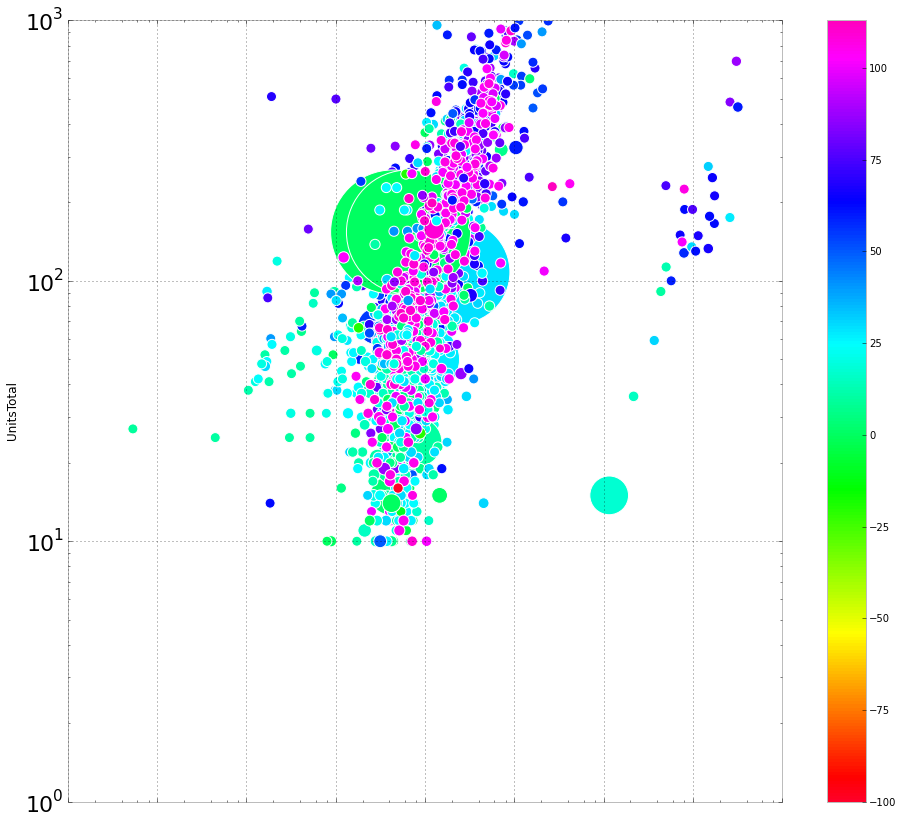

In [27]:
bblnrgdatacut['YearBuilt'][bblnrgdatacut['YearBuilt']<1800]=1800

bblnrgdatacut.plot(kind='scatter',x='nrg',y='UnitsTotal', fontsize=22, colormap='gist_rainbow', alpha = 1, marker='o',  figsize=(16, 14), loglog=True,  xlim=(1000,1e11), ylim=(1,1000), c=bblnrgdatacut['YearBuilt']-1900, s=bblnrgdatacut['UnitsTotal']/bblnrgdatacut['UnitsRes']*100)